In [ ]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import yfinance as yf
import seaborn as sb
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM, GRU, Bidirectional, Dropout, Convolution1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, MaxPooling1D

In [3]:
import datetime
start= '2010-01-01'
end= '2019-12-31'
#|dataset=yf.download('CSCO',start,end)
dataset=yf.download('CSCO',start,datetime.date.today())
#dataset=data.DataReader('TSLA', 'yahoo', start, datetime.date.today())
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,24.110001,24.840000,24.010000,24.690001,17.394129,59853700
2010-01-05,24.600000,24.730000,24.379999,24.580000,17.316633,45124500
2010-01-06,24.540001,24.740000,24.340000,24.420000,17.203909,35715700
2010-01-07,24.299999,24.570000,24.170000,24.530001,17.281412,31531200
2010-01-08,24.379999,24.700001,24.250000,24.660000,17.372995,39115900


In [4]:
dataset=dataset.reset_index()
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,24.110001,24.840000,24.010000,24.690001,17.394129,59853700
1,2010-01-05,24.600000,24.730000,24.379999,24.580000,17.316633,45124500
2,2010-01-06,24.540001,24.740000,24.340000,24.420000,17.203909,35715700
3,2010-01-07,24.299999,24.570000,24.170000,24.530001,17.281412,31531200
4,2010-01-08,24.379999,24.700001,24.250000,24.660000,17.372995,39115900
...,...,...,...,...,...,...,...
3295,2023-02-06,48.070000,48.279999,47.520000,47.570000,47.570000,13991600
3296,2023-02-07,47.240002,48.150002,46.970001,47.840000,47.840000,16675200
3297,2023-02-08,47.380001,47.540001,46.770000,46.959999,46.959999,18905500
3298,2023-02-09,47.230000,47.410000,46.430000,46.730000,46.730000,18598400


In [5]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [6]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,24.110001,24.840000,24.010000,24.690001,17.394129,59853700
1,2010-01-05,24.600000,24.730000,24.379999,24.580000,17.316633,45124500
2,2010-01-06,24.540001,24.740000,24.340000,24.420000,17.203909,35715700
3,2010-01-07,24.299999,24.570000,24.170000,24.530001,17.281412,31531200
4,2010-01-08,24.379999,24.700001,24.250000,24.660000,17.372995,39115900
...,...,...,...,...,...,...,...
3295,2023-02-06,48.070000,48.279999,47.520000,47.570000,47.570000,13991600
3296,2023-02-07,47.240002,48.150002,46.970001,47.840000,47.840000,16675200
3297,2023-02-08,47.380001,47.540001,46.770000,46.959999,46.959999,18905500
3298,2023-02-09,47.230000,47.410000,46.430000,46.730000,46.730000,18598400


In [ ]:
dataset.shape

(3300, 7)

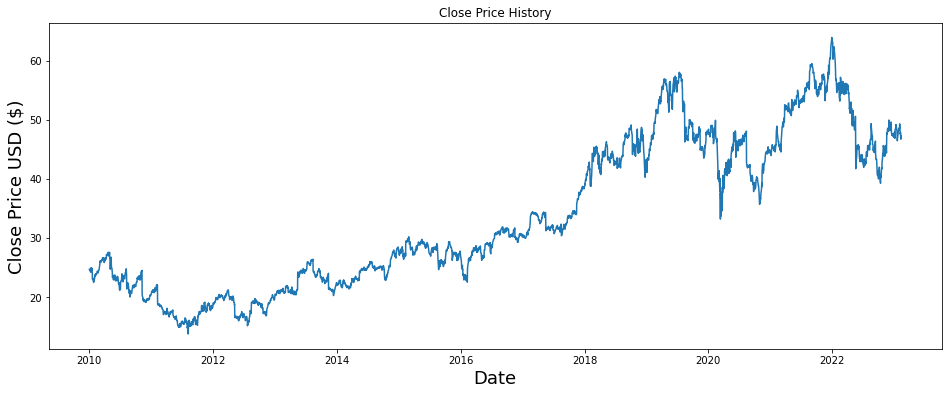

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(dataset['Date'],dataset['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

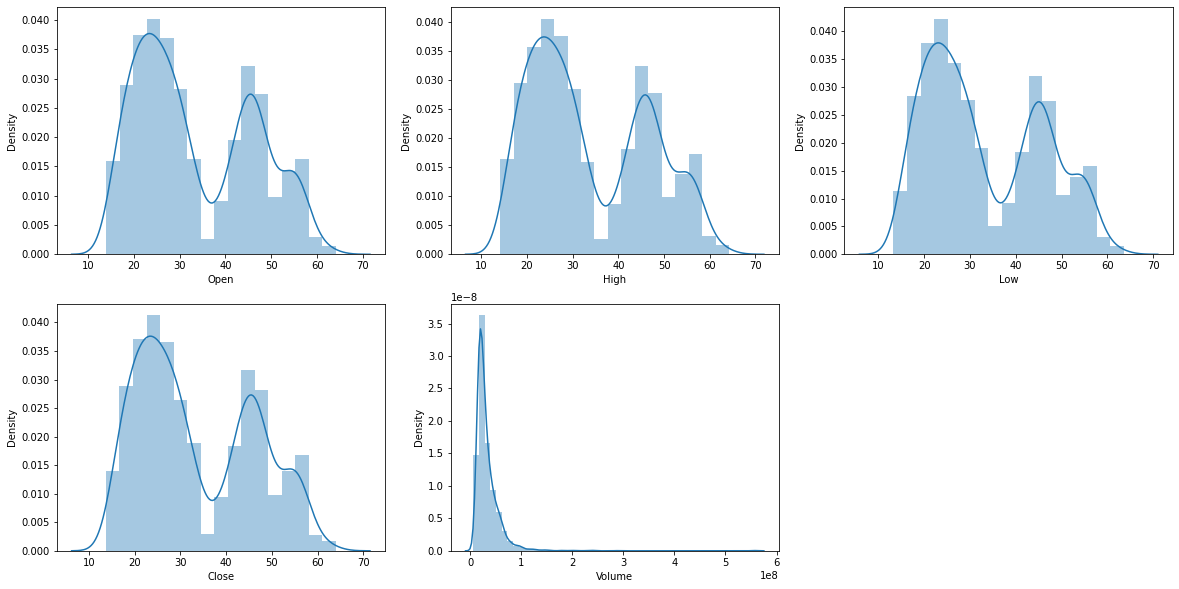

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))

 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(dataset[col])
plt.show()

In the distribution plot of **OHLC** data, we can see two peaks which means the data has varied significantly in two regions. And the Volume data is left-skewed.

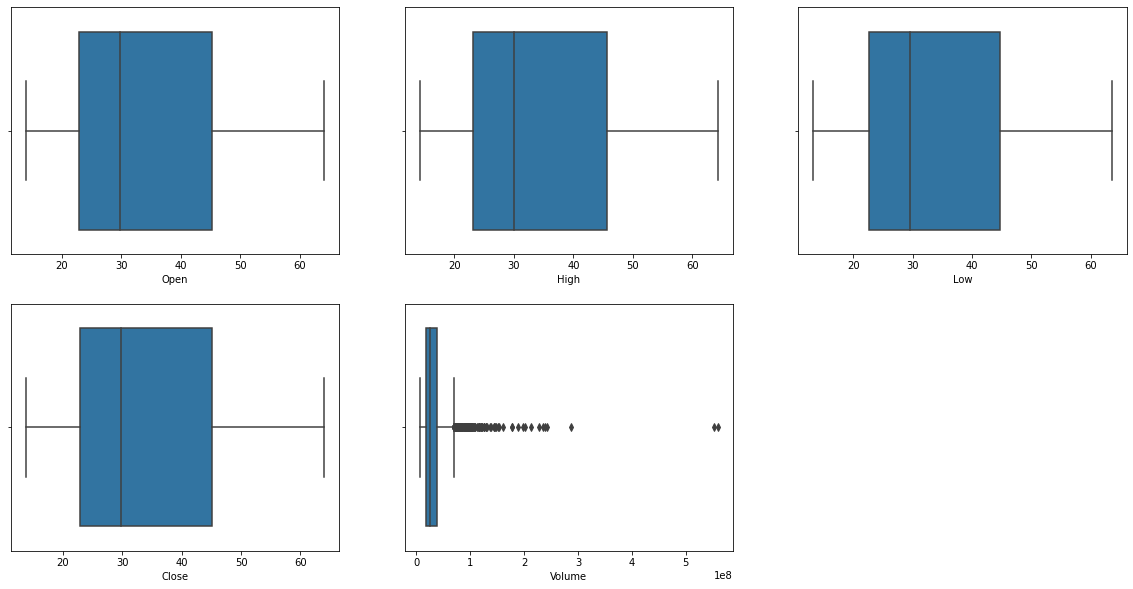

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(dataset[col])
plt.show()

From the above **boxplots**, we can conclude that only volume data contains outliers in it but the data in the rest of the columns are free from any outlier.

In [ ]:
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset['year'] = dataset['Date'].dt.year

In [ ]:
dataset['is_quarter_end'] = np.where(dataset['month']%3==0,1,0)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day,month,year,is_quarter_end
0,2010-01-04,24.110001,24.840000,24.010000,24.690001,17.394129,59853700,4,1,2010,0
1,2010-01-05,24.600000,24.730000,24.379999,24.580000,17.316633,45124500,5,1,2010,0
2,2010-01-06,24.540001,24.740000,24.340000,24.420000,17.203915,35715700,6,1,2010,0
3,2010-01-07,24.299999,24.570000,24.170000,24.530001,17.281410,31531200,7,1,2010,0
4,2010-01-08,24.379999,24.700001,24.250000,24.660000,17.372997,39115900,8,1,2010,0


A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company’s performance. These quarterly results affect the stock prices heavily which is why we have added this feature because this can be a helpful feature for the learning model.

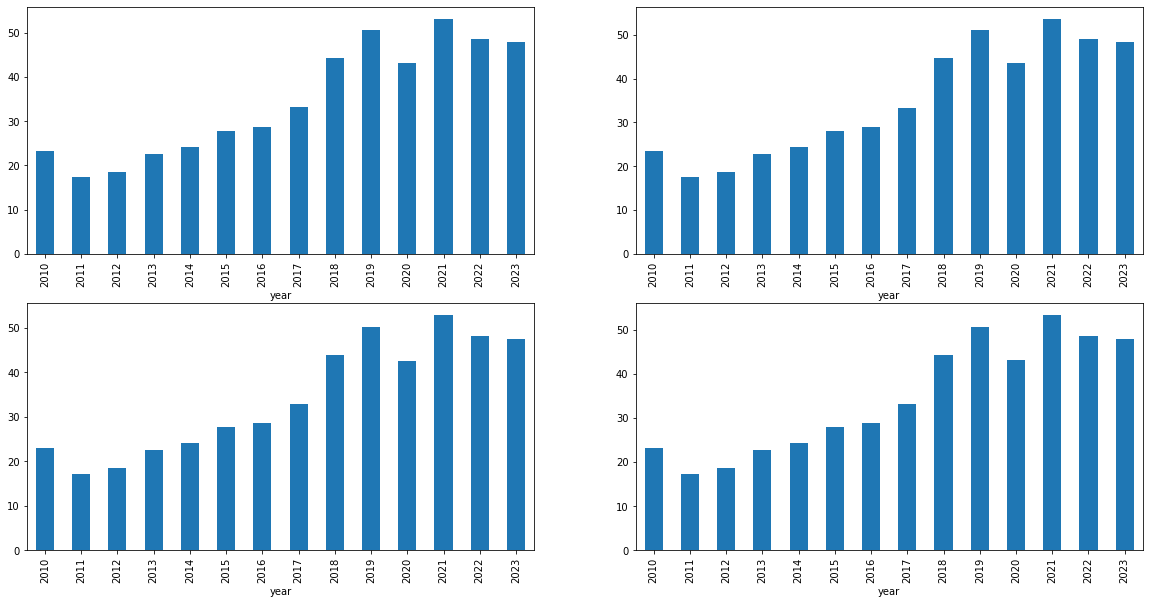

In [ ]:
data_grouped = dataset.groupby('year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

From the above bar graph, we can conclude that the stock prices have increased consecutively from the year 2011 to that in 2019.

In [ ]:
dataset.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Adj Close,Volume,day,month,year
is_quarter_end,,,,,,,,,
0,33.611699,33.918852,33.300633,33.622436,28.808522,3.309958e+07,15.668488,6.033242,2016.088798
1,33.638632,33.957808,33.335589,33.643089,28.765660,3.147228e+07,15.767210,7.434783,2016.003623


Here are some of the important observations of the above-grouped data:


*   Prices are almost same in the months which are quarter end as compared to that of
the non-quarter end months.
*   The volume of trades is very lower in the months which are quarter end.





In [ ]:
dataset['open-close']  = dataset['Open'] - dataset['Close']
dataset['low-high']  = dataset['Low'] - dataset['High']
dataset['target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

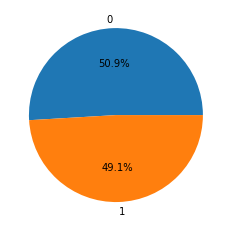

In [ ]:
plt.pie(dataset['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

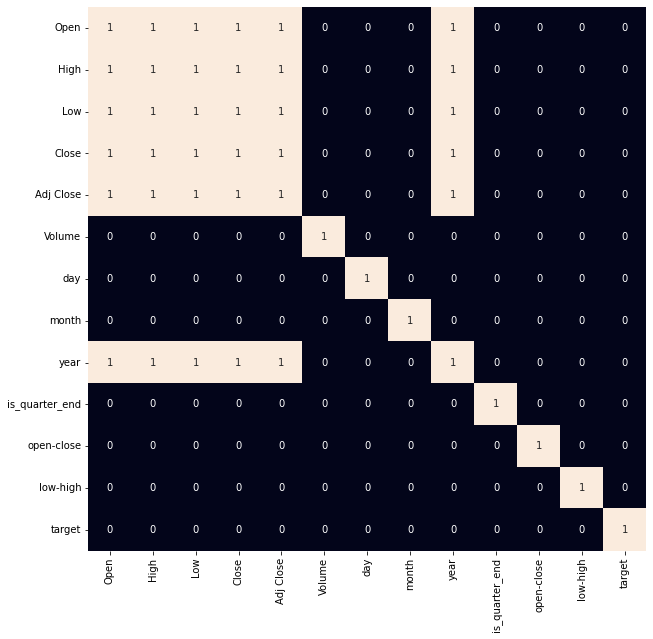

In [ ]:
plt.figure(figsize=(10, 10))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(dataset.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap, we can say that there is a high correlation between OHLC that is pretty obvious, and the added features are not highly correlated (except 'year') with each other or previously provided features which means that we are good to go and build our model.

In [ ]:
#moving average (100 days)
ma100=dataset.Close.rolling(100).mean()
ma200=dataset.Close.rolling(200).mean()
#ma100

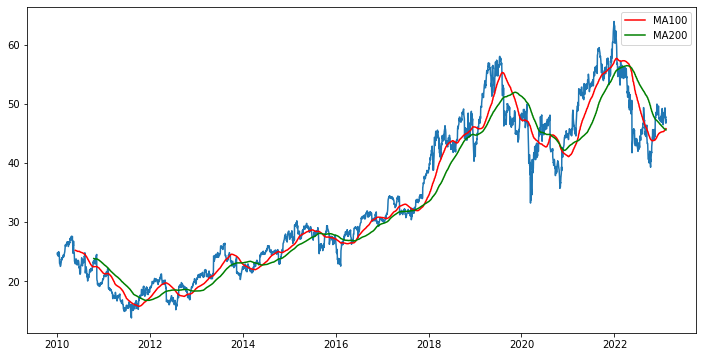

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dataset.Date,dataset.Close)
plt.plot(dataset.Date,ma100,'r',label='MA100')
plt.plot(dataset.Date,ma200,'g',label='MA200')
plt.legend()
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [8]:
train_data=pd.DataFrame(dataset['Close'][0:int(len(dataset)*.70)])
test_data=pd.DataFrame(dataset['Close'][int(len(dataset)*.70):int(len(dataset))])
print(train_data.shape,test_data.shape)

(2310, 1) (990, 1)


In [27]:
test_data

,Close
2310,51.919998
2311,52.150002
2312,52.590000
2313,52.740002
2314,53.200001
...,...
3295,47.570000
3296,47.840000
3297,46.959999
3298,46.730000


In [9]:
training_data=scaler.fit_transform(train_data)
training_data

array([[0.28811779],
       [0.28522608],
       [0.28101999],
       ...,
       [0.99737113],
       [0.98738172],
       [0.9815983 ]])

In [ ]:
training_data.shape

(2310, 1)

In [10]:
time_step=100
x_train=[]
y_train=[]

for i in range(time_step,training_data.shape[0]):
  x_train.append(training_data[i-time_step: i])
  y_train.append(training_data[i, 0])

In [11]:
x_train, y_train =np.array(x_train), np.array(y_train)

In [18]:
x_train.shape

(2210, 100, 1)

In [12]:
from sklearn import metrics
# Build the LSTM model
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(60, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(80, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))

model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 120)         53280     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 100, 120)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 160)         96960     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100, 160)          0

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True, monitor='loss',mode='min')
model.fit(x_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
35/35 [==============================] - 39s 781ms/step - loss: 0.0390
Epoch 2/50
35/35 [==============================] - 30s 848ms/step - loss: 0.0030
Epoch 3/50
35/35 [==============================] - 31s 875ms/step - loss: 0.0021
Epoch 4/50
35/35 [==============================] - 30s 858ms/step - loss: 0.0023
Epoch 5/50
35/35 [==============================] - 28s 810ms/step - loss: 0.0017
Epoch 6/50
35/35 [==============================] - 28s 793ms/step - loss: 0.0016
Epoch 7/50
35/35 [==============================] - 28s 795ms/step - loss: 0.0016
Epoch 8/50
35/35 [==============================] - 28s 805ms/step - loss: 0.0014
Epoch 9/50
35/35 [==============================] - 32s 884ms/step - loss: 0.0015
Epoch 10/50
35/35 [==============================] - 27s 782ms/step - loss: 0.0014
Epoch 11/50
35/35 [==============================] - 28s 805ms/step - loss: 0.0012
Epoch 12/50
35/35 [==============================] - 28s 805ms/step - loss: 0.0013
Epoch 13/50
3

In [14]:
model.save('model.h5')

In [15]:
past_time_index=train_data.tail(time_step)
final_test_data=past_time_index.append(test_data,ignore_index=True)

In [26]:
final_test_data.shape

(1090, 1)

In [16]:
final_testing_data=scaler.fit_transform(final_test_data)

In [17]:
x_test=[]
y_test=[]

for i in range(time_step,final_testing_data.shape[0]):
  x_test.append(final_testing_data[i-time_step: i])
  y_test.append(final_testing_data[i, 0])

In [19]:
x_test, y_test= np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

(990, 100, 1) (990,)


In [20]:
y_pred=model.predict(x_test)

31/31 [==============================] - 7s 184ms/step


In [23]:
scale_factor=1/scaler.scale_
y_pred1=y_pred * scale_factor
y_test1=y_test * scale_factor

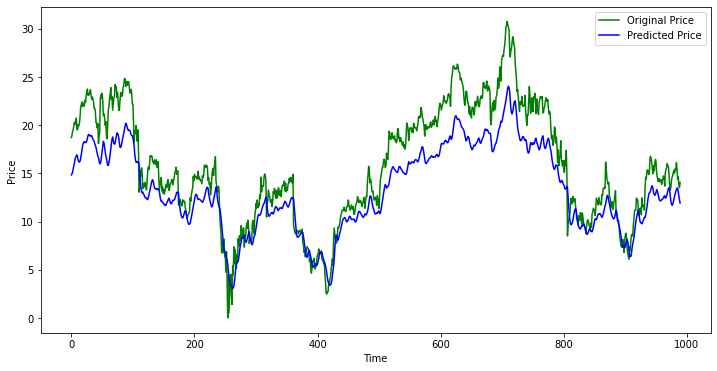

In [24]:
plt.figure(figsize=(12,6))
plt.plot(y_test1, 'g', label ='Original Price')
plt.plot(y_pred1,'blue', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

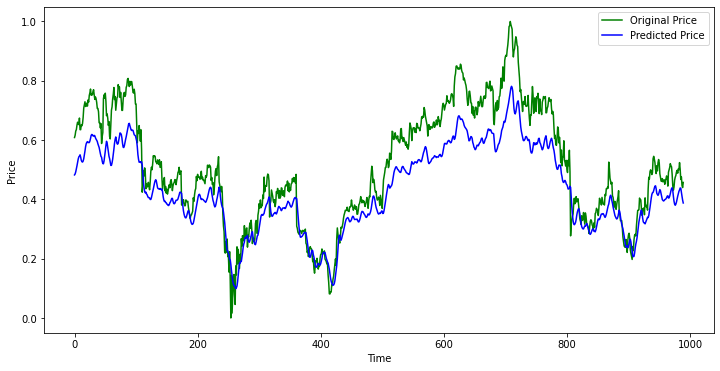

In [22]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'g', label ='Original Price')
plt.plot(y_pred,'blue', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import log


r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)

print("MSE :", mse)
print("MAE :" ,mae)
print("RMSE :" ,rmse)
print("R2_score :",r2)

MSE : 0.009738070621407118
MAE : 0.08363966788664885
RMSE : 0.09868166304540635
R2_score : 0.7380953845354769


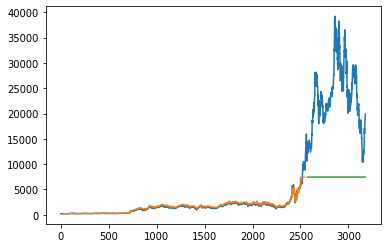

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
test_data['prediction']=scaler.inverse_transform(y_pred)
test_data.head(100)

,Close,prediction
2310,51.919998,48.041485
2311,52.150002,48.143032
2312,52.590000,48.360924
2313,52.740002,48.658653
2314,53.200001,48.987228
...,...,...
2405,56.619999,52.663425
2406,56.529999,52.450256
2407,56.930000,52.209686
2408,56.470001,52.153156


In [33]:
final_test_data

,Close
0,45.709999
1,44.669998
2,45.820000
3,45.939999
4,45.459999
...,...
1085,47.570000
1086,47.840000
1087,46.959999
1088,46.730000
